In [62]:
from google.colab import drive
drive.mount('/content/MyDrive/')

Drive already mounted at /content/MyDrive/; to attempt to forcibly remount, call drive.mount("/content/MyDrive/", force_remount=True).


In [63]:
import os
import numpy as np
import librosa
import librosa.display
from tqdm import tqdm
import pandas as pd
from sklearn.model_selection import train_test_split

# **Labels**

In [64]:
dataset_path = "/content/MyDrive/MyDrive/iiii/AutSED_New_Name"
files = os.listdir(dataset_path)

emotion_dict = {'A':'Angry', 'S':'Sad', 'H':'Happy', 'N':'Neutral'}
emotion_list = [emotion_dict[f[3]] for f in files]

dataset_info = pd.DataFrame({'Dirs':files, 'Emotions':emotion_list})
dataset_info.to_csv('files.csv', index=False)
dataset_info

,Dirs,Emotions
0,F26H1R2D09.wav,Happy
1,F26A1R1D09.wav,Angry
2,F26A2R2D08.wav,Angry
3,F26A3R1D08.wav,Angry
4,F25S3R1D08.wav,Sad
...,...,...
1484,F25S3R1D09.wav,Sad
1485,F26A4R1D09.wav,Angry
1486,F25S4R1D09.wav,Sad
1487,F25S2R2D09.wav,Sad


In [65]:
dataset_info['Emotions'].value_counts()

Neutral    380
Happy      375
Angry      374
Sad        360
Name: Emotions, dtype: int64

# **OneHot**

In [66]:
labels = pd.get_dummies(dataset_info['Emotions']).values
labels

array([[0, 1, 0, 0],
       [1, 0, 0, 0],
       [1, 0, 0, 0],
       ...,
       [0, 0, 0, 1],
       [0, 0, 0, 1],
       [1, 0, 0, 0]], dtype=uint8)

In [67]:
dataset_path = "/content/MyDrive/MyDrive/iiii/AutSED_New_Name"
files = os.listdir(dataset_path)

sample_rate = 44100
duration = 5
data_list = []
for f in files:
  path = os.path.join(dataset_path, f)
  data, rate = librosa.load(path, sr=sample_rate)
  data = librosa.util.fix_length(data, duration*sample_rate)
  data_list.append(data)

data = np.vstack(data_list)
data.shape

(1489, 220500)

In [68]:
# save_path = "/content/MyDrive/MyDrive/TA_amirkabir/Fall_2022/Teacher/"
# with open(os.path.join(save_path, 'Data_5_Sec.npy'), 'wb') as f:
#   np.save(f, data)

# **Features**

In [69]:
def get_melSpectrogram(data, sr=44100):
  mel_list = []
  with tqdm(total=data.shape[0]) as bar:
    for i in range(data.shape[0]):
      S = librosa.feature.melspectrogram(data[i], sr=sr, n_mels=128, fmax=8000)
      mel = librosa.power_to_db(S)
      # img = librosa.display.specshow(mel, x_axis='time',
                        #  y_axis='mel', sr=sr,
                        #  fmax=8000)
      mel_list.append(np.expand_dims(mel, 0))
      bar.update(1)
  return np.concatenate(mel_list, axis=0)

In [70]:



# def get_melSpectrogram(data, sr=44100):
#   mfccs = []
#   for i in tqdm(data):
#     mfcc = librosa.feature.mfcc(y = i, sr =sr, n_mfcc = 13)
#     mfccs.append(np.expand_dims(mfcc,0))
#   return np.concatenate(mfccs, axis=0)

In [71]:
features = get_melSpectrogram(data)
features.shape

100%|██████████| 1489/1489 [00:30<00:00, 48.28it/s]


(1489, 128, 431)

In [72]:
features = np.expand_dims(features, -1)
features.shape

(1489, 128, 431, 1)

** split data to train test and validation**

In [73]:
X_train, X_test, y_train, y_test = train_test_split(features,labels, test_size=0.3, random_state=20)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.3, random_state=20)
X_train.shape

(729, 128, 431, 1)

# **Model**

In [74]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [75]:
def make_model():
  model = keras.Sequential()
  #model.add(keras.Input())
  model.add(keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(128, 431, 1)))
  model.add(keras.layers.Dropout(0.1))
  model.add(keras.layers.MaxPool2D(3,3))
  model.add(keras.layers.Conv2D(64, (3, 3), activation='relu'))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.MaxPool2D(3,3))
  model.add(keras.layers.Conv2D(128, (3, 3), activation='relu'))
  model.add(keras.layers.Dropout(0.2))
  model.add(keras.layers.MaxPool2D(3,3))

  model.add(keras.layers.Flatten())

  model.add(keras.layers.Dense(64, activation='relu'))
  model.add(keras.layers.Dense(16, activation='relu'))
  model.add(keras.layers.Dense(4, activation='softmax'))

  loss = tf.keras.losses.BinaryCrossentropy()
  opt = keras.optimizers.Adam(learning_rate=0.001)
  model.compile(optimizer=opt, loss=loss, metrics=['accuracy'])

  return model

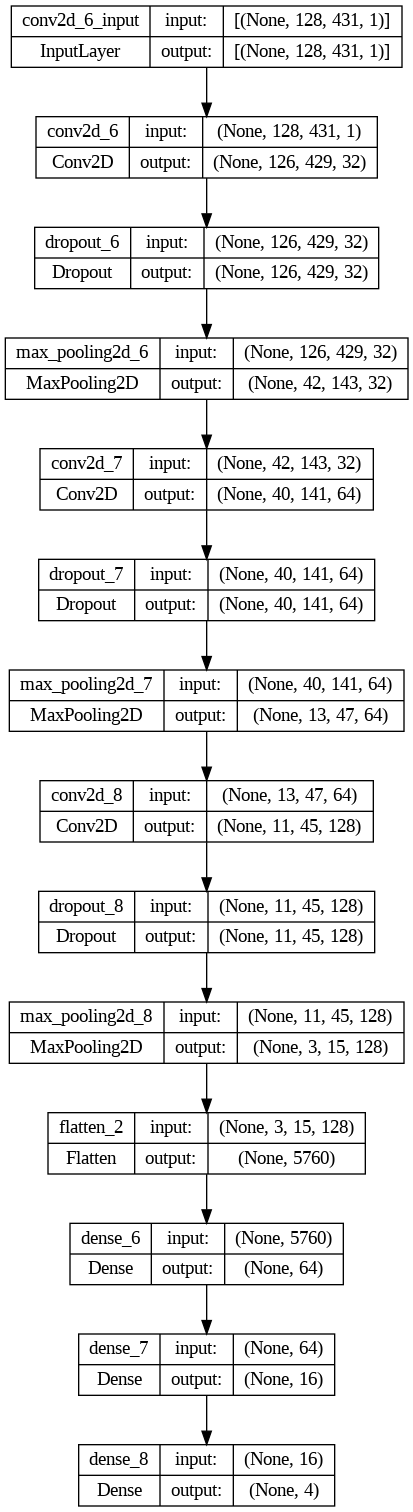

In [76]:
model = make_model()
keras.utils.plot_model(model,show_shapes= True)
# model.summary()


In [77]:
history = model.fit(X_train, y_train, batch_size=64, epochs=100, validation_split=0.2)

Epoch 1/100
10/10 [==============================] - 2s 119ms/step - loss: 1.3613 - accuracy: 0.2521 - val_loss: 0.6867 - val_accuracy: 0.3151
Epoch 2/100
10/10 [==============================] - 1s 99ms/step - loss: 0.6923 - accuracy: 0.2796 - val_loss: 0.6470 - val_accuracy: 0.2466
Epoch 3/100
10/10 [==============================] - 1s 98ms/step - loss: 0.6537 - accuracy: 0.2058 - val_loss: 0.6561 - val_accuracy: 0.2466
Epoch 4/100
10/10 [==============================] - 1s 99ms/step - loss: 0.6344 - accuracy: 0.2127 - val_loss: 0.6773 - val_accuracy: 0.3973
Epoch 5/100
10/10 [==============================] - 1s 97ms/step - loss: 0.6317 - accuracy: 0.3036 - val_loss: 0.5957 - val_accuracy: 0.2671
Epoch 6/100
10/10 [==============================] - 1s 98ms/step - loss: 0.6124 - accuracy: 0.2830 - val_loss: 0.6299 - val_accuracy: 0.4041
Epoch 7/100
10/10 [==============================] - 1s 98ms/step - loss: 0.5995 - accuracy: 0.3533 - val_loss: 0.5764 - val_accuracy: 0.3288
Epoch

Text(0.5, 1.0, 'accuracy for train ')

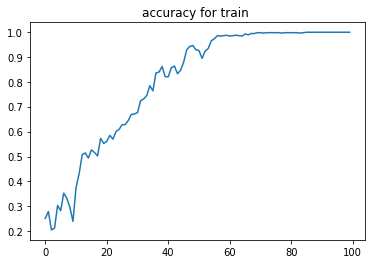

In [78]:
plt.plot(history.history['accuracy'])
plt.title("accuracy for train ")

Text(0.5, 1.0, 'loss for train ')

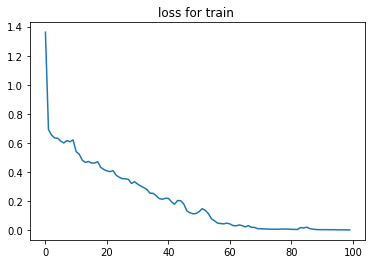

In [79]:
plt.plot(history.history['loss'])
plt.title("loss for train ")

Text(0.5, 1.0, 'validation accuracy')

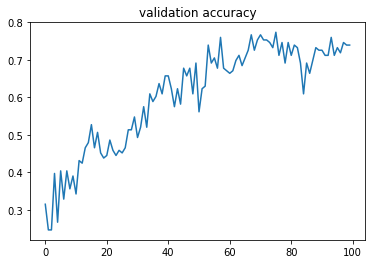

In [80]:
plt.plot(history.history['val_accuracy'])
plt.title("validation accuracy")

Text(0.5, 1.0, 'validation loss')

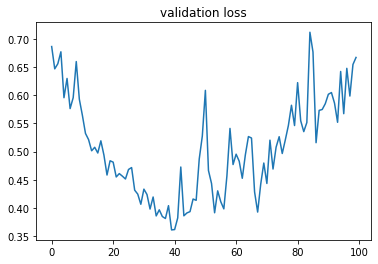

In [81]:
plt.plot(history.history['val_loss'])
plt.title("validation loss")

# **Evaluation**

**Confusion matrix for valids and compute accuracy**

In [82]:
y_pred = model.predict(X_val)

10/10 [==============================] - 0s 17ms/step


In [83]:
y_pred

array([[2.3706843e-07, 3.5570304e-07, 9.9946815e-01, 5.3128268e-04],
       [9.2804803e-10, 9.4613338e-11, 9.9999976e-01, 2.8488546e-07],
       [8.2168899e-06, 3.8962537e-07, 9.9997842e-01, 1.2946895e-05],
       ...,
       [9.9984193e-01, 2.8775979e-05, 1.2934794e-04, 1.3074757e-09],
       [7.7361619e-06, 9.9999225e-01, 7.8661269e-13, 4.3998236e-13],
       [9.9999940e-01, 1.9413140e-09, 5.8069242e-07, 5.1566752e-16]],
      dtype=float32)

In [84]:
y_pred.shape

(313, 4)

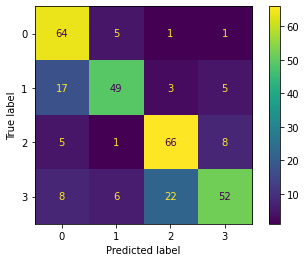

In [85]:
cm = confusion_matrix(np.argmax(y_val, -1), np.argmax(y_pred, -1))
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [86]:
eval = model.evaluate(X_val, y_val, batch_size=1)
eval

313/313 [==============================] - 1s 3ms/step - loss: 0.6360 - accuracy: 0.7380


[0.636041522026062, 0.7380191683769226]

In [87]:
np.argmax(labels, -1)[:10]

array([1, 0, 0, 0, 3, 1, 0, 0, 0, 3])

In [88]:
np.argmax(y_pred, -1)[:10]

array([2, 2, 2, 1, 1, 2, 1, 2, 3, 2])

**test data**


In [89]:
y_pred = model.predict(X_test)

14/14 [==============================] - 0s 14ms/step


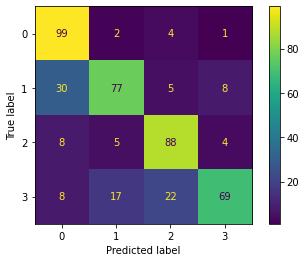

In [90]:
cm = confusion_matrix(np.argmax(y_test, -1), np.argmax(y_pred, -1))
disp = ConfusionMatrixDisplay(cm)
disp.plot()

In [91]:
eval = model.evaluate(X_test, y_test, batch_size=1)
eval

447/447 [==============================] - 1s 3ms/step - loss: 0.6812 - accuracy: 0.7450


[0.6811923980712891, 0.744966447353363]